In [1]:
!pip install alibi -q
!pip install alibi-detect -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.8/380.8 kB 4.9 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorflow as tf
import pandas as pd
import scipy
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)
tf.random.set_seed(0)

# Load data
red = pd.read_csv("https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-red.csv", sep=';')
white = pd.read_csv("https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-white.csv", sep=';')


white, red = np.asarray(white, np.float32), np.asarray(red, np.float32)
n_white, n_red = white.shape[0], red.shape[0]

col_maxes = white.max(axis=0)
white, red = white / col_maxes, red / col_maxes
white, red = white[np.random.permutation(n_white)], red[np.random.permutation(n_red)]
X = white[:, :-1]
X_corr = red[:, :-1]

X_train = X[:(n_white//2)]
X_ref = X[(n_white//2):(3*n_white//4)]
X_h0 = X[(3*n_white//4):]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [3]:
red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [12]:
white, red = np.asarray(white, np.float32), np.asarray(red, np.float32)
n_white, n_red = white.shape[0], red.shape[0]

col_maxes = white.max(axis=0)
white, red = white / col_maxes, red / col_maxes
white, red = white[np.random.permutation(n_white)], red[np.random.permutation(n_red)]
X = white[:, :-1]
X_corr = red[:, :-1]

In [13]:
X_train = X[:(n_white//2)]
X_ref = X[(n_white//2):(3*n_white//4)]
X_h0 = X[(3*n_white//4):]

In [14]:
pca = PCA(2)
pca.fit(X_train)
X_ref = np.concatenate([X_train, X_ref], axis=0)

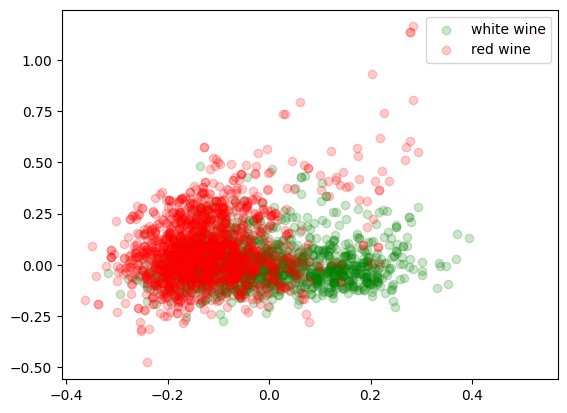

In [8]:
enc_h0 = pca.transform(X_h0)
enc_h1 = pca.transform(X_corr)

plt.scatter(enc_h0[:,0], enc_h0[:,1], alpha=0.2, color='green', label='white wine')
plt.scatter(enc_h1[:,0], enc_h1[:,1], alpha=0.2, color='red', label='red wine')
plt.legend(loc='upper right')
plt.show()


In [15]:
from alibi_detect.cd import MMDDriftOnline

ert = 50
window_size = 10

cd = MMDDriftOnline(
    X_ref, ert, window_size, backend='pytorch', n_bootstraps=2500
)



Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


In [10]:
# Define a function to simulate a single run and return the run-time
def time_run(cd, X, window_size):
    n = X.shape[0]
    perm = np.random.permutation(n)
    t = 0
    cd.reset_state()
    while True:
        pred = cd.predict(X[perm[t%n]])
        if pred['data']['is_drift'] == 1:
            return t
        else:
            t += 1
# Simulate run-time under no-drift
n_runs = 25
times_h0 = [time_run(cd, X_h0, window_size) for _ in range(n_runs)]
print(f"Average run-time under no-drift: {np.mean(times_h0)}")

# Simulate run-time under drift
n_runs = 25
times_h1 = [time_run(cd, X_corr, window_size) for _ in range(n_runs)]
print(f"Average run-time under drift: {np.mean(times_h1)}")


Average run-time under no-drift: 49.68
Average run-time under drift: 3.04


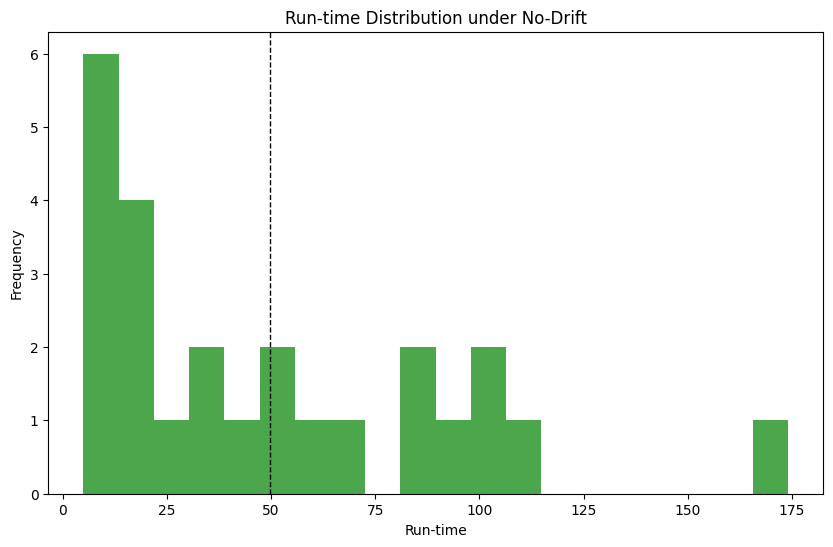

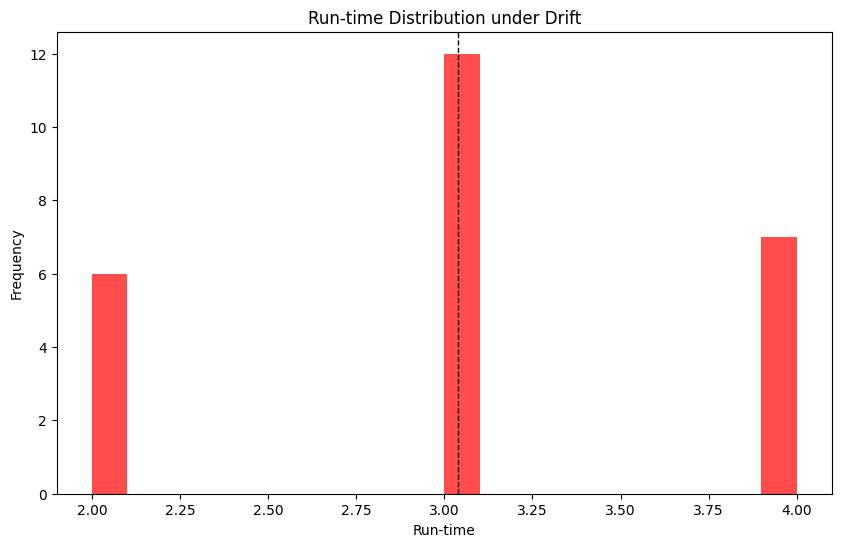

In [11]:
# Visualize run-time distribution under no-drift
plt.figure(figsize=(10, 6))
plt.hist(times_h0, bins=20, color='green', alpha=0.7)
plt.axvline(np.mean(times_h0), color='black', linestyle='dashed', linewidth=1)
plt.xlabel('Run-time')
plt.ylabel('Frequency')
plt.title('Run-time Distribution under No-Drift')
plt.show()

# Visualize run-time distribution under drift
plt.figure(figsize=(10, 6))
plt.hist(times_h1, bins=20, color='red', alpha=0.7)
plt.axvline(np.mean(times_h1), color='black', linestyle='dashed', linewidth=1)
plt.xlabel('Run-time')
plt.ylabel('Frequency')
plt.title('Run-time Distribution under Drift')
plt.show()
